In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, SimpleRNN, Dense

In [4]:
train_csv_path = "drive/MyDrive/Deep_learning/HW6/train.csv"
train_df = pd.read_csv(train_csv_path)
train_df.index = train_df["time"]
train_df.drop("time", inplace=True, axis=1)

In [5]:
train_df

,value
time,
0,52.483570
1,49.352749
2,53.314735
3,57.711823
4,48.934444
...,...
995,62.874840
996,73.281693
997,67.510696


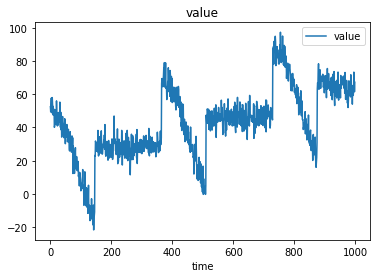

In [6]:
def show_raw_visualization(data):
    ax = data.plot(title="value")

show_raw_visualization(train_df)

In [7]:
test_csv_path = "drive/MyDrive/Deep_learning/HW6/test.csv"
test_df = pd.read_csv(test_csv_path)
test_df.index = test_df["time"]
test_df.drop("time", inplace=True, axis=1)

In [8]:
test_df

,value
time,
1000,71.344719
1001,68.985519
1002,64.675201
1003,61.157360
1004,67.898438
...,...
1456,88.624756
1457,86.796989
1458,91.373253


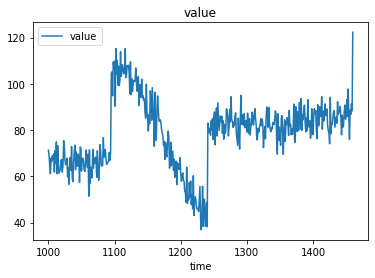

In [9]:
show_raw_visualization(test_df)

In [10]:
past = 40
future = 1
learning_rate = 0.001
batch_size = 32
epochs = 300
step = 1

In [11]:
y_start = past + future - 1
x_end = len(train_df) - past - future

x_train = train_df.loc[:x_end]
y_train = train_df.loc[y_start:]

sequence_length = int(past / step)

In [12]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    batch_size=batch_size,
)

In [13]:
test_start_point = 999

In [14]:
y_start = test_start_point + past + future
x_end = test_start_point + (len(test_df) - past - future + 1)

x_test = test_df.loc[:x_end]
y_test = test_df.loc[y_start:]

sequence_length = int(past / step)

In [15]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    batch_size=batch_size,
)

In [16]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 40, 1)
Target shape: (32, 1)


In [17]:
inputs = Input(shape=(None, inputs.shape[2]))
rnn_out_1 = SimpleRNN(64, return_sequences=True)(inputs)
rnn_out_2 = SimpleRNN(64)(rnn_out_1)
outputs = Dense(1)(rnn_out_2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 64)          4224      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 12,545
Trainable params: 12,545
Non-trainable params: 0
_________________________________________________________________


In [18]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_test,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/300
29/29 [==============================] - 3s 42ms/step - loss: 1034.4468 - mean_absolute_error: 28.0614 - val_loss: 4971.7866 - val_mean_absolute_error: 68.8267

Epoch 00001: val_loss improved from inf to 4971.78662, saving model to model_checkpoint.h5
Epoch 2/300
29/29 [==============================] - 1s 28ms/step - loss: 753.9280 - mean_absolute_error: 22.7287 - val_loss: 4656.9751 - val_mean_absolute_error: 66.5003

Epoch 00002: val_loss improved from 4971.78662 to 4656.97510, saving model to model_checkpoint.h5
Epoch 3/300
29/29 [==============================] - 1s 29ms/step - loss: 665.5025 - mean_absolute_error: 21.0256 - val_loss: 4423.8218 - val_mean_absolute_error: 64.7236

Epoch 00003: val_loss improved from 4656.97510 to 4423.82178, saving model to model_checkpoint.h5
Epoch 4/300
29/29 [==============================] - 1s 29ms/step - loss: 602.1807 - mean_absolute_error: 19.7819 - val_loss: 4216.2676 - val_mean_absolute_error: 63.0999

Epoch 00004: val_loss im

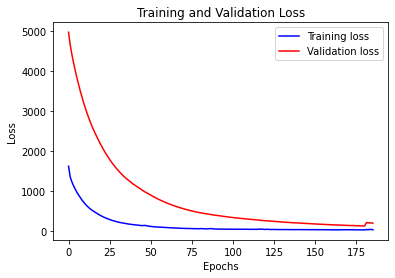

In [19]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

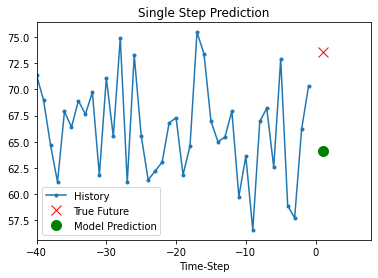

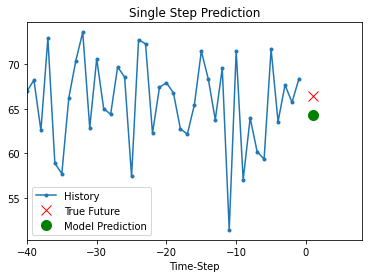

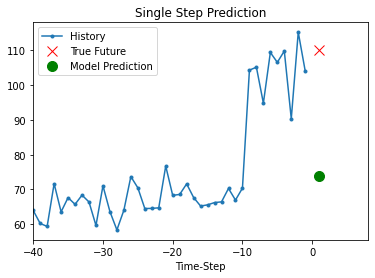

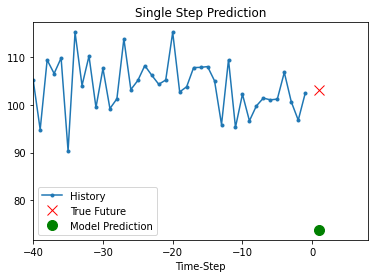

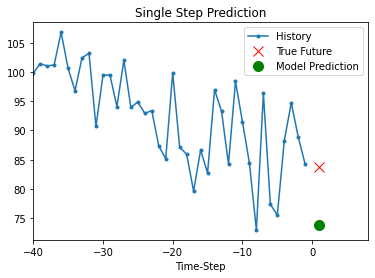

In [20]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 3) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_test.take(5):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

In [21]:
dataset_test_1 = keras.preprocessing.timeseries_dataset_from_array(
    x_test,
    y_test,
    sequence_length=sequence_length,
    batch_size=440,
)

In [22]:
for batch in dataset_test_1.take(1):
    x, y = batch

print("Input shape:", x.numpy().shape)
print("Target shape:", y.numpy().shape)

Input shape: (382, 40, 1)
Target shape: (382, 1)


In [24]:
score = model.evaluate(x, y, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 196.41783142089844
Test accuracy: 10.737601280212402


In [25]:
prediction_df = features = pd.DataFrame(model.predict(x), columns = ["pred_value"])
prediction_df.index.name = "time"

In [26]:
prediction_df

,pred_value
time,
0,64.088058
1,67.375504
2,64.604782
3,66.384819
4,64.821198
...,...
377,73.742393
378,73.749016
379,73.762985


In [27]:
true_df = features = pd.DataFrame(y.numpy(), columns = ["value"])
true_df.index.name = "time"

In [28]:
true_df

,value
time,
0,73.549332
1,62.859653
2,70.572067
3,65.010925
4,64.365334
...,...
377,85.028709
378,91.354874
379,86.278694


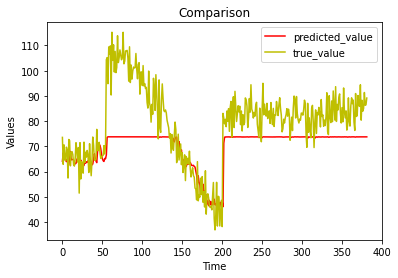

In [29]:
def show_result_visualization(prediction, true, title):
    prediction_value = prediction["pred_value"]
    true_value = true["value"]
    time = range(len(true_df.index))
    plt.figure()
    plt.plot(time, prediction_value, "r", label="predicted_value")
    plt.plot(time, true_value, "y", label="true_value")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()
    plt.show()


show_result_visualization(prediction_df, true_df, "Comparison")